# matplotlib

## setup

In [3]:
import torch as t
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## images

In [16]:
# plot the image and optinal labels in a grid
def plot(*args, n_col=None, figsize=None, axis_off=True):
    '''Plot the images in a grid with optional labels
    usage: plot(img1, img2, ...)
    usage: plot(img1, label1, img2, label2, ...)
    optional: n_col=3, figsize=(12, 8), axis_off=True

    img: torch.Tensor of shape (C, H, W) or (H, W, C)
    label: str
    '''
    # prepare the elements to plot as (image, label)
    elems = []
    for el in args:
        if isinstance(el, t.Tensor):
            if el.dim() == 4: el = el[0] # if picture is a batch, take the first one
            assert el.dim() == 3, f"Wrong image shape {el.shape}"
            if el.shape[0] == 3: el = el.permute(1, 2, 0) # if image is (C, H, W), convert to (H, W, C)
            if el.requires_grad: el = el.detach()
            elems.append([el])
        elif isinstance(el, str): elems[-1].append(el)
        else: raise ValueError(f"Wrong element ({type(el)}) {repr(el)}")
    elems = [(el[0], el[1] if len(el) == 2 else None) for el in elems]

    # plot the images
    n_col = n_col or len(elems)
    n_row = math.ceil(len(elems) / n_col)
    figsize = figsize or (n_col * 4, n_row * 4)
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1: ax = np.array([ax])
    for i, (img, label) in enumerate(elems):
        idx = (i,) if n_row == 1 or n_col == 1 else (i // n_col, i % n_col)
        if label: ax[idx].set_title(label)
        ax[idx].imshow(img)
    # remove the axis
    for i in range(n_row * n_col):
        idx = (i,) if n_row == 1 or n_col == 1 else (i // n_col, i % n_col)
        if axis_off: ax[idx].axis('off')
    plt.tight_layout()
    plt.show()

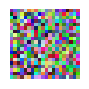

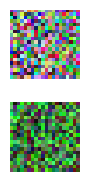

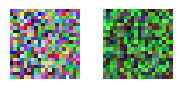

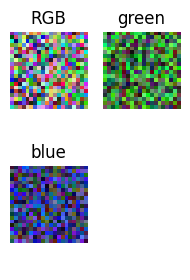

In [17]:
# usage demo
im = t.rand([3, 20, 20])
im2 = t.rand([20, 20, 3]) * t.tensor([0.5, 1., 0.5])
im3 = t.rand([20, 20, 3]) * t.tensor([0.5, 0.5, 1.])

plot(im, figsize=(1, 1))
plot(im, im2, n_col=1, figsize=(1, 2))
plot(im, im2, figsize=(2, 1))
plot(im, 'RGB', im2, 'green', im3, 'blue', n_col=2, figsize=(2, 3))

## graph

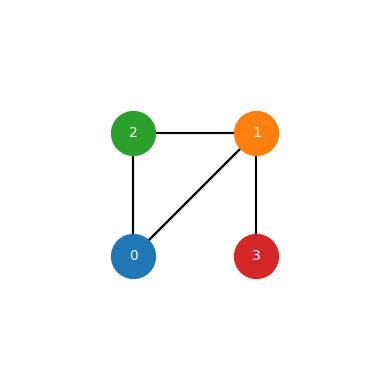

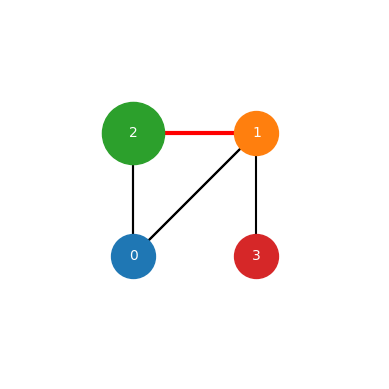

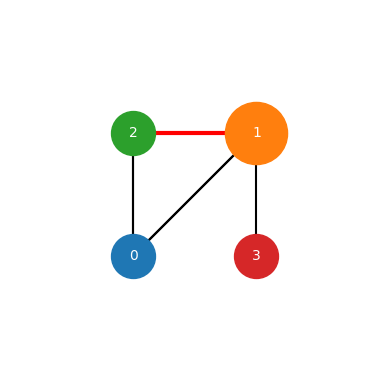

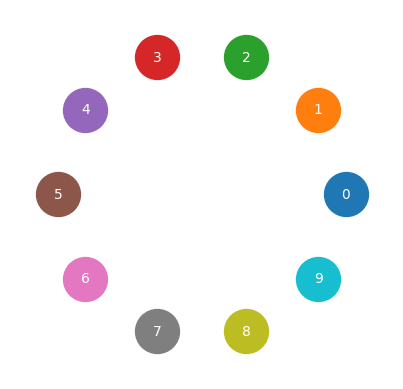

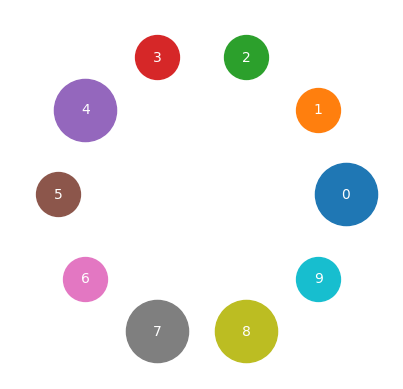

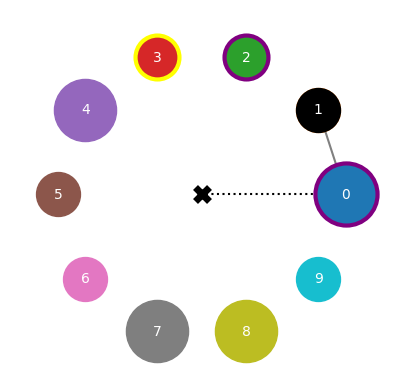

In [37]:
class Node:
    def __init__(self, idx, embedding, neighbors=None):
        self.idx = idx
        self.embedding = embedding
        self.neighbors = set(neighbors) if neighbors else set()

    def __lt__(self, other): # add a way to sort nodes to make the heapq happy
        return self.idx < other.idx

    def __repr__(self):
        return f'{self.idx} {self.neighbors=}'

def plot_graph(graph, hl_nodes=[], hl_edges=[], ll_nodes=[], ll_edges=[], border_nodes=[], hl_border_nodes=[], target=None, doted_start=None, xlim=None, ylim=None, ax=None):
    if ax is None: _, ax = plt.subplots()
    ax.clear()
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.axis('off')
    ax.set_aspect('equal')

    def _border(idx):
        if idx in hl_border_nodes:
            return {
                'edgecolors': 'yellow',
                'linewidths': 3,
            }
        if idx in border_nodes:
            return {
                'edgecolors': 'purple',
                'linewidths': 3,
            }
        return {}

    # draw graph
    for node in graph:
        # plot node
        x, y = node.embedding
        ax.scatter(x, y, s=1000, zorder=2, **_border(node.idx))
        ax.text(x, y, node.idx, color='white', ha='center', va='center')
        # plot edges
        for neighbor in node.neighbors:
            x0, y0 = node.embedding
            x1, y1 = graph[neighbor].embedding
            ax.plot([x0, x1], [y0, y1], color='black', zorder=1)

    # draw target
    if target:
        ax.plot(*target, markersize=10, marker="x", color='k', mew=5)
        if doted_start is not None:
            start = graph[doted_start].embedding
            x_values = [start[0], target[0]]
            y_values = [start[1], target[1]]
            ax.plot(x_values, y_values, linestyle=':', color='black')

    # draw lowlights
    for node in ll_nodes:
        x, y = graph[node].embedding
        ax.scatter(x, y, color='black', s=1000, zorder=2, **_border(node))

    for node, neighbor in ll_edges:
        x0, y0 = graph[node].embedding
        x1, y1 = graph[neighbor].embedding
        ax.plot([x0, x1], [y0, y1], color='grey', zorder=1)

    # draw highlights
    for node in hl_nodes:
        x, y = graph[node].embedding
        node_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][node]
        ax.scatter(x, y, color=node_color, s=2000, zorder=2, **_border(node))
            
    for node, neighbor in hl_edges:
        x0, y0 = graph[node].embedding
        x1, y1 = graph[neighbor].embedding
        ax.plot([x0, x1], [y0, y1], color='red', linewidth=3, zorder=1)

    if xlim: ax.set_xlim(*xlim)
    else: ax.set_xlim(min(node.embedding[0] for node in graph) - 1, max(node.embedding[0] for node in graph) + 1)
    if ylim: ax.set_ylim(*ylim)
    else: ax.set_ylim(min(node.embedding[1] for node in graph) - 1, max(node.embedding[1] for node in graph) + 1)

def test_square():
    graph = [
        Node(0, (1, 1), [1, 2]),
        Node(1, (2, 2), [0, 2]),
        Node(2, (1, 2), [0, 1]),
        Node(3, (2, 1), [1]),
    ]
    plot_graph(graph)
    plot_graph(graph, hl_nodes=[2], hl_edges=[(2, 1)])
    plot_graph(graph, hl_nodes=[1], hl_edges=[(2, 1)])

def test_circle():
    def generate_circle_points(r, cx=0, cy=0, num_points=10):
        angles = np.linspace(0, 2 * np.pi, num_points + 1)[:-1]
        x = cx + r * np.cos(angles)
        y = cy + r * np.sin(angles)
        return list(zip(x, y))

    points = generate_circle_points(r=3)
    graph = [Node(idx, pos) for idx, pos in enumerate(points)]
    plot_graph(graph)
    plot_graph(graph, hl_nodes=[0, 4, 8, 7])
    plot_graph(graph, hl_nodes=[0, 4, 8, 7], ll_nodes=[1], ll_edges=[(0, 1)], border_nodes=[0, 2], hl_border_nodes=[3], target=(0, 0), doted_start=0)

test_square()
test_circle()